# Reference Weather Station Data Analysis and Clustering for ROM Model Input Selection

This notebook processes and analyzes reference weather station data collected between March and August 2024. The primary objective is to identify representative and extreme weather days for use in Reduced Order Modeling (ROM). The workflow includes:

## Key Steps in This Notebook:

### 1. Data Preparation:
   - Load and clean raw weather station data (temperature, wind, solar irradiance, etc.).
   - Convert and interpolate missing values.
   - Visualize weather data for individual days.

### 2. Daily Profile Clustering:
   - Identify complete 24-hour days for analysis.
   - Standardize daily profiles using key features:
     - Average Temperature (°C)
     - Wind Speed (m/s)
     - Wind Direction (°)
     - Solar Irradiance (W/m²)
   - Apply K-Means clustering to group similar days.
   - Use Elbow Method to validate the number of clusters.

### 3. Cluster Analysis:
   - Compute average diurnal (hourly) profiles for each cluster.
   - Visualize average profiles to understand cluster characteristics.
   - Select the most representative day per cluster based on distance to cluster centers.

### 4. Extreme Weather Day Identification:
   - Identify days with lowest and highest extremes for temperature, wind speed, and solar irradiance.
   - Filter all selections to retain non-rainy days only (precipitation ≤ 0.1 mm).

### 5. Summary and Visualization:
   - Provide a summary of selected representative and extreme days.
   - Highlight selected days and cluster groupings across the full data timeline.
   - Create comprehensive plots showing daily weather variation, cluster assignments, and selected days.


## Outputs:
- Cluster assignments for all valid days.
- List of selected representative days (1 per cluster).
- List of extreme high/low days for key weather variables.
- Visualizations to support selection validation and overall data understanding.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# ==============================
# 1. Load and Parse Weather Station Data
# ==============================

# Load CSV file (raw weather station data)
data = pd.read_csv(r'..\RawMeasurementData\Atmosphere\RefStation_detailed_data_localtime_March-August2024.csv')

# Ensure that "Date" and "Time" columns are present for datetime construction
if 'Date' in data.columns and 'Time' in data.columns:
    # Combine "Date" and "Time" into a single datetime column
    data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
    # Set datetime as index for time-based operations
    data.set_index('Datetime', inplace=True)
    # Remove redundant "Date" and "Time" columns
    data.drop(columns=['Date', 'Time'], inplace=True)
else:
    print("'Date' and 'Time' columns not found in the dataset!")

data.head()

,TM°C,TX°C,TN°C,HRM%,PPTmm,VVM (10 m)km/h,DVM (10 m)graus,VVX (10 m)km/h,PMhPa,RSW/m2
Datetime,,,,,,,,,,
2024-03-01 01:00:00,11.1,11.1,11.0,85,0.0,13.0,34,28.1,1008.6,0
2024-03-01 01:30:00,11.0,11.1,10.8,82,0.0,4.7,327,14.4,1008.8,0
2024-03-01 02:00:00,10.7,11.0,10.6,83,0.1,9.7,313,21.2,1009.1,0
2024-03-01 02:30:00,10.7,10.9,10.6,80,0.0,10.1,328,21.2,1008.5,0
2024-03-01 03:00:00,10.9,11.4,10.6,72,0.0,15.5,328,32.0,1008.4,0


In [3]:
# ==============================
# 2. Clean and Prepare Data Columns
# ==============================

# Define mapping for column renaming to standardized labels
numeric_columns = {
    "TM°C": "Avg Temperature (C)",
    "TX°C": "Max Temperature (C)",
    "TN°C": "Min Temperature(C)",
    "HRM%": "Relative Humidity",
    "PPTmm": "Precipitation (mm)",
    "VVM (10 m)km/h": "Avg Windspeed (km/h)",
    "DVM (10 m)graus": "Avg Wind Direction",
    "VVX (10 m)km/h": "Max Windspeed (km/h)",
    "PMhPa": "Air Pressure (hPa)",
    "RSW/m2": "Avg Solar Irradiance (W/m2)"
}

# Rename columns based on the provided mapping
data.rename(columns=numeric_columns, inplace=True)

# Convert all columns to numeric, coercing invalid values to NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Remove duplicate timestamps, keeping the first occurrence
data = data[~data.index.duplicated(keep='first')]

# Sort data chronologically
data = data.sort_index()

# Interpolate missing values linearly
data.interpolate(method='linear', inplace=True)

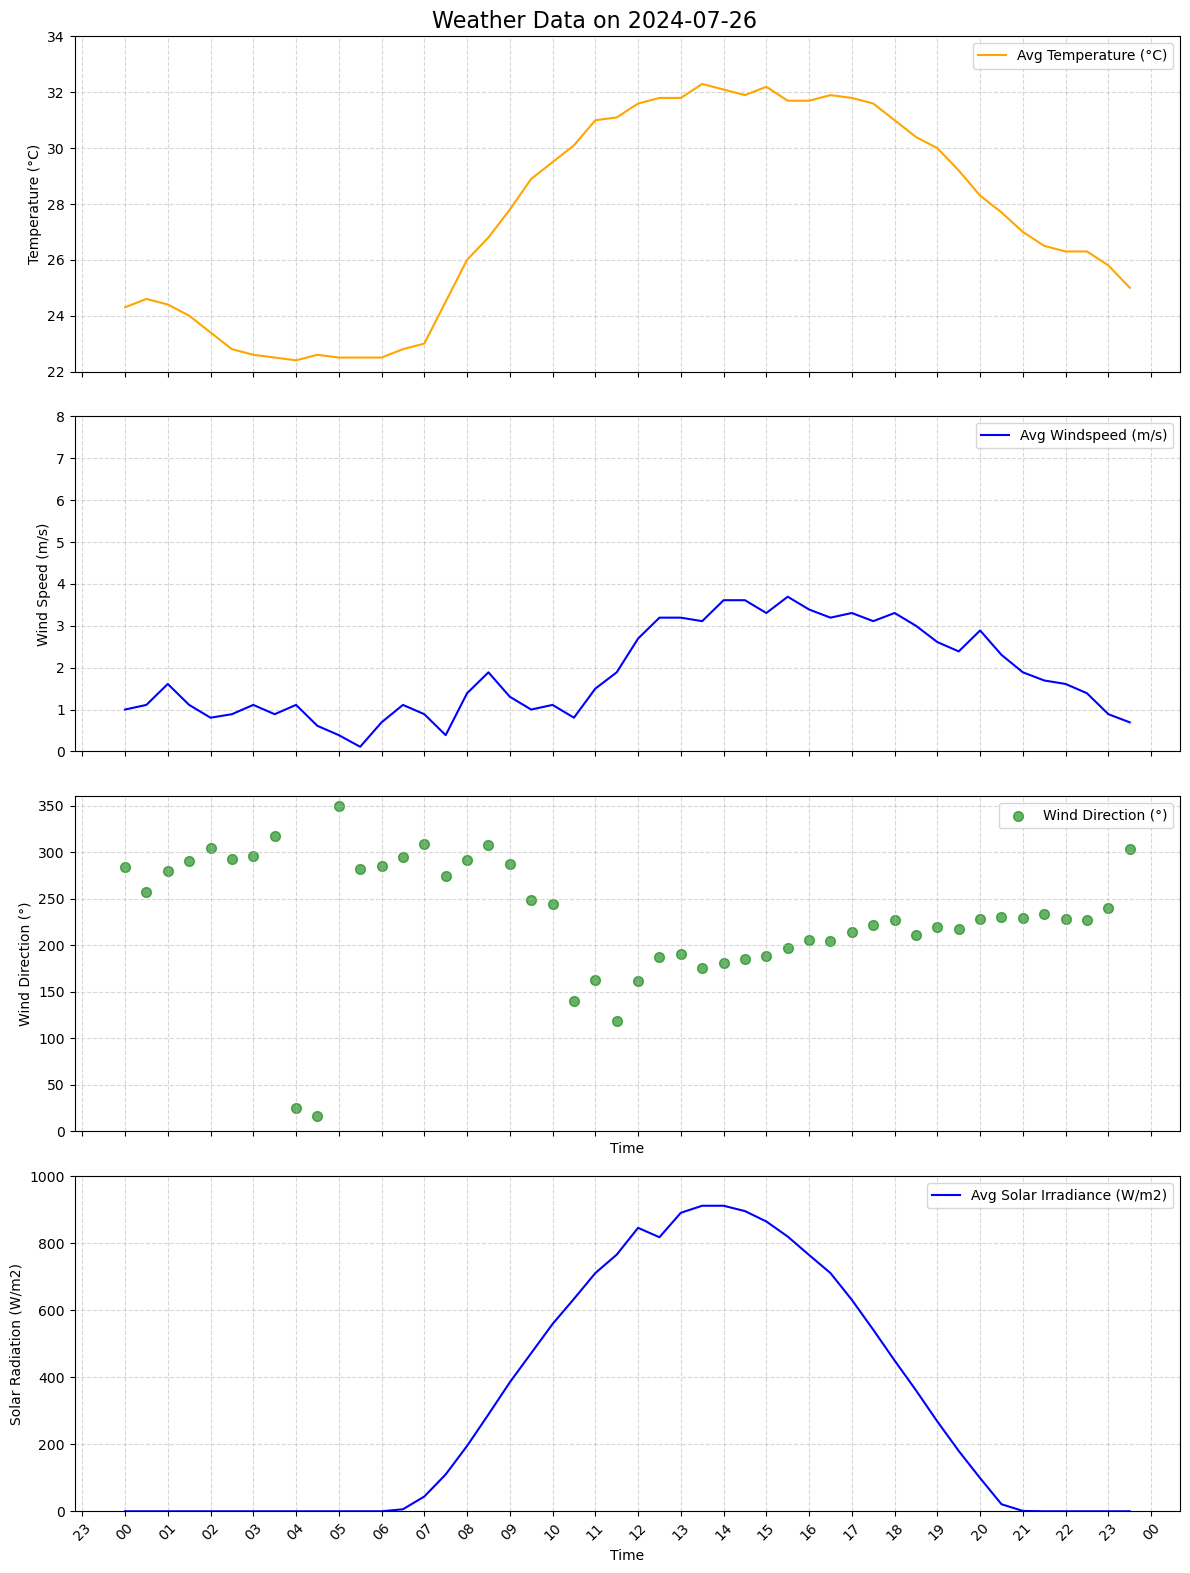

In [4]:
# ==============================
# 3. Plot Weather Data for a Specific Date
# ==============================

# Filter data for a specific day
date1 = '2024-07-26'
data_filtered = data.loc[date1]

# Convert wind speed from km/h to m/s
data_filtered['Avg Windspeed (m/s)'] = data_filtered['Avg Windspeed (km/h)'] / 3.6

# Create subplots for Temperature, Wind Speed, Wind Direction, and Solar Irradiance
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

# Plot 1: Average Temperature
axes[0].plot(data_filtered.index, data_filtered['Avg Temperature (C)'],
             color='orange', linewidth=1.5, label='Avg Temperature (°C)')
axes[0].set_ylim(22, 34)
axes[0].set_ylabel("Temperature (°C)")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# Plot 2: Wind Speed
axes[1].plot(data_filtered.index, data_filtered['Avg Windspeed (m/s)'],
             color='blue', linewidth=1.5, label='Avg Windspeed (m/s)')
axes[1].set_ylim(0, 8)
axes[1].set_ylabel("Wind Speed (m/s)")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)

# Plot 3: Wind Direction
axes[2].scatter(data_filtered.index, data_filtered['Avg Wind Direction'],
                color='green', marker='o', s=50, alpha=0.6, label='Wind Direction (°)')
axes[2].set_ylim(0, 360)
axes[2].set_ylabel("Wind Direction (°)")
axes[2].set_xlabel("Time")
axes[2].xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Hourly ticks
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%H'))    # Hour format
axes[2].legend()
axes[2].grid(True, linestyle="--", alpha=0.5)

# Plot 4: Solar Irradiance
axes[3].plot(data_filtered.index, data_filtered['Avg Solar Irradiance (W/m2)'],
             color='blue', linewidth=1.5, label='Avg Solar Irradiance (W/m2)')
axes[3].set_ylim(0, 1000)
axes[3].set_ylabel("Solar Radiation (W/m2)")
axes[3].set_xlabel("Time")
axes[3].xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Hourly ticks
axes[3].xaxis.set_major_formatter(mdates.DateFormatter('%H'))    # Hour format
axes[3].legend()
axes[3].grid(True, linestyle="--", alpha=0.5)

# Formatting and display
plt.suptitle(f"Weather Data on {date1}", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Clustering

In [5]:
# Set the number of threads for parallel processing
os.environ["OMP_NUM_THREADS"] = "10"

# Display column names in the dataset
data.columns

Index(['Avg Temperature (C)', 'Max Temperature (C)', 'Min Temperature(C)',
       'Relative Humidity', 'Precipitation (mm)', 'Avg Windspeed (km/h)',
       'Avg Wind Direction', 'Max Windspeed (km/h)', 'Air Pressure (hPa)',
       'Avg Solar Irradiance (W/m2)'],
      dtype='object')

# Cluster with Winddir And windspeed

Found 153 full 24-hour days
Valid days for clustering: 153


c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

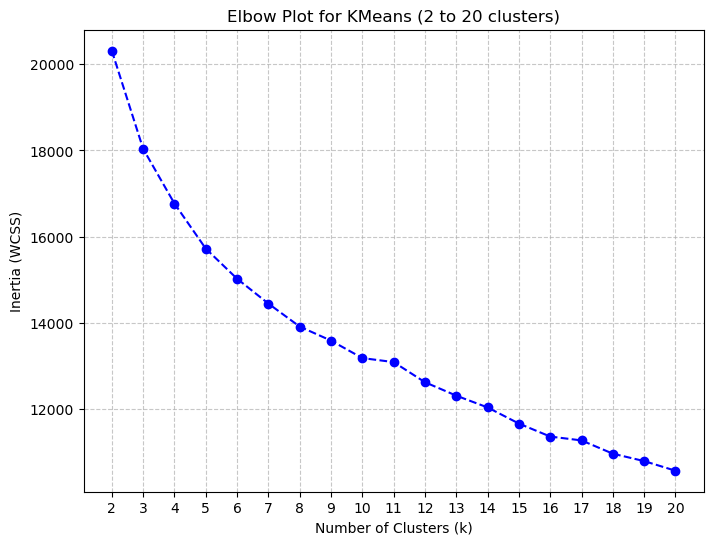

In [6]:
# ==============================
# 4. Extract Full 24-Hour Days and Build Daily Feature Vectors
# ==============================

# Convert wind speed from km/h to m/s
data['Avg Windspeed (m/s)'] = data['Avg Windspeed (km/h)'] / 3.6

# Identify full 24-hour days (48 half-hour intervals)
day_counts = data.groupby(data.index.date).size()
full_day_dates = day_counts[day_counts == 48].index
print(f"Found {len(full_day_dates)} full 24-hour days")

# Filter dataset for full days only
mask = pd.to_datetime(data.index.date).isin(pd.to_datetime(full_day_dates))
full_days = data[mask]
if full_days.empty:
    print("No full days found after filtering. Check your data completeness.")

# Define features for clustering
feature_list = [
    'Avg Temperature (C)',
    'Avg Windspeed (m/s)',
    'Avg Wind Direction',
    'Avg Solar Irradiance (W/m2)'
]

# Build daily vectors: each day = 192 values (4 features × 48 intervals)
daily_vectors = []
valid_dates = []

for date_val in full_day_dates:
    group = full_days[full_days.index.date == date_val]
    vec = []
    for feat in feature_list:
        vals = group[feat].values
        if len(vals) == 48 and not np.isnan(vals).any():
            vec.extend(vals)
    if len(vec) == 4 * 48:
        daily_vectors.append(vec)
        valid_dates.append(date_val)

X = np.array(daily_vectors)
print(f"Valid days for clustering: {len(valid_dates)}")

# ==============================
# 5. Perform KMeans Clustering on Daily Feature Vectors
# ==============================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# ==============================
# 6. Evaluate Optimal Cluster Number with Elbow Plot
# ==============================

inertias = []
K_range = range(2, 21)

for k in K_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_test.fit(X_scaled)
    inertias.append(kmeans_test.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertias, 'o--', color='blue', linewidth=1.5, markersize=6)
plt.title('Elbow Plot for KMeans (2 to 20 clusters)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.xticks(K_range)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Columns after reset_index(): Index(['Datetime', 'Avg Temperature (C)', 'Max Temperature (C)',
       'Min Temperature(C)', 'Relative Humidity', 'Precipitation (mm)',
       'Avg Windspeed (km/h)', 'Avg Wind Direction', 'Max Windspeed (km/h)',
       'Air Pressure (hPa)', 'Avg Solar Irradiance (W/m2)',
       'Avg Windspeed (m/s)'],
      dtype='object')
Before merge shape: (7344, 13)
After merge shape: (7344, 14)
            Date  Cluster
6360  2024-07-11        3
3832  2024-05-19        0
4452  2024-06-01        2
750   2024-03-16        5
4498  2024-06-02        2
3917  2024-05-21        2
2209  2024-04-16        5
172   2024-03-04        1
3890  2024-05-21        2
2713  2024-04-26        5
cluster_means shape: (288, 6)


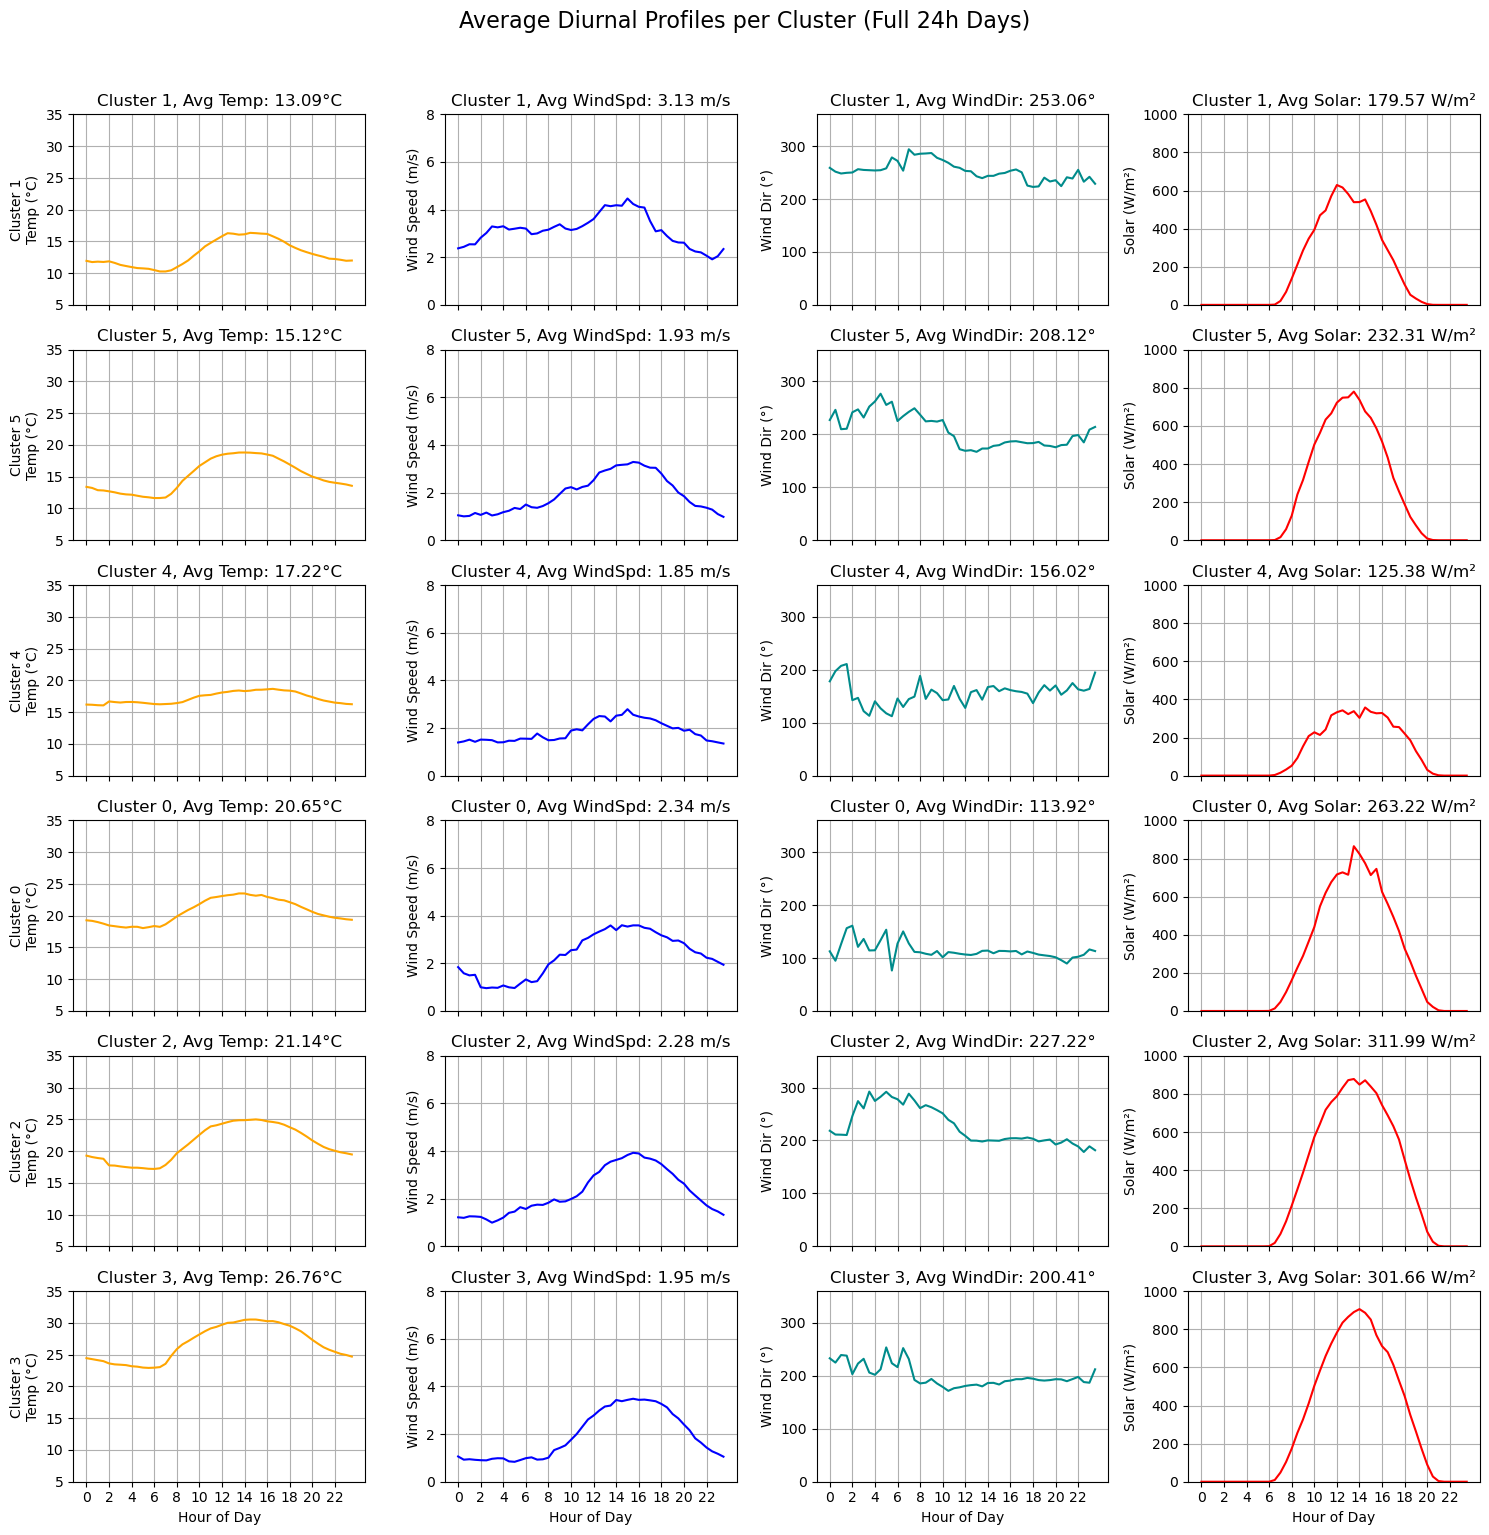

Representative days per cluster:
Cluster 0: 2024-05-24
Cluster 1: 2024-04-01
Cluster 2: 2024-05-29
Cluster 3: 2024-07-20
Cluster 4: 2024-03-24
Cluster 5: 2024-04-26


In [7]:
# ==============================
# 7. Merge Cluster Labels and Compute Cluster-Averaged Diurnal Profiles
# ==============================

# Create DataFrame of daily cluster assignments
daily_cluster_df = pd.DataFrame({'Date': valid_dates, 'Cluster': labels})

# Reset index of full_days for merging
full_days_reset = full_days.reset_index()
print("Columns after reset_index():", full_days_reset.columns)

# Rename index column for clarity
full_days_reset.rename(columns={full_days_reset.columns[0]: 'OriginalDatetime'}, inplace=True)

# Extract date from datetime
full_days_reset['Date'] = full_days_reset['OriginalDatetime'].dt.date

# Merge cluster labels into the full_days data
before_merge_shape = full_days_reset.shape
full_days_merged = full_days_reset.merge(daily_cluster_df, on='Date', how='left')
after_merge_shape = full_days_merged.shape
print("Before merge shape:", before_merge_shape)
print("After merge shape:", after_merge_shape)
print(full_days_merged[['Date', 'Cluster']].sample(10))

# Restore datetime index after merge
full_days_merged.set_index('OriginalDatetime', inplace=True)
full_days_merged.index = pd.to_datetime(full_days_merged.index)

# Add decimal hour for plotting
full_days_merged['Hour'] = full_days_merged.index.hour + full_days_merged.index.minute / 60

# Compute average hourly profiles per cluster
cluster_means = full_days_merged.groupby(['Cluster', 'Hour'])[feature_list].mean().reset_index()
print("cluster_means shape:", cluster_means.shape)

# ==============================
# 8. Plot Average Diurnal Profiles for Each Cluster
# ==============================

if cluster_means.empty:
    print("cluster_means is empty! Possibly no merges matched or no cluster labels assigned.")
else:
    # Order clusters by mean daily temperature
    cluster_order = (
        full_days_merged.groupby("Cluster")["Avg Temperature (C)"]
        .mean()
        .sort_values()
        .index.tolist()
    )

    fig, axes = plt.subplots(6, 4, figsize=(15, 15), sharex=True)

    # Color definitions for each feature
    colors = {
        'Avg Temperature (C)': 'orange',
        'Avg Windspeed (m/s)': 'blue',
        'Avg Wind Direction': 'darkcyan',
        'Avg Solar Irradiance (W/m2)': 'red'
    }

    for i, cluster in enumerate(cluster_order):
        subset = cluster_means[cluster_means['Cluster'] == cluster]

        # Temperature
        axes[i, 0].plot(subset['Hour'], subset['Avg Temperature (C)'], color=colors['Avg Temperature (C)'])
        axes[i, 0].set_ylabel(f'Cluster {cluster}\nTemp (°C)')
        axes[i, 0].set_ylim(5, 35)
        axes[i, 0].set_title(f'Cluster {cluster}, Avg Temp: {subset["Avg Temperature (C)"].mean():.2f}°C')
        axes[i, 0].grid()

        # Wind Speed
        axes[i, 1].plot(subset['Hour'], subset['Avg Windspeed (m/s)'], color=colors['Avg Windspeed (m/s)'])
        axes[i, 1].set_ylabel('Wind Speed (m/s)')
        axes[i, 1].set_ylim(0, 8)
        axes[i, 1].set_title(f'Cluster {cluster}, Avg WindSpd: {subset["Avg Windspeed (m/s)"].mean():.2f} m/s')
        axes[i, 1].grid()

        # Wind Direction
        axes[i, 2].plot(subset['Hour'], subset['Avg Wind Direction'], color=colors['Avg Wind Direction'])
        axes[i, 2].set_ylabel('Wind Dir (°)')
        axes[i, 2].set_ylim(0, 360)
        axes[i, 2].set_title(f'Cluster {cluster}, Avg WindDir: {subset["Avg Wind Direction"].mean():.2f}°')
        axes[i, 2].grid()

        # Solar Irradiance
        axes[i, 3].plot(subset['Hour'], subset['Avg Solar Irradiance (W/m2)'], color=colors['Avg Solar Irradiance (W/m2)'])
        axes[i, 3].set_ylabel('Solar (W/m²)')
        axes[i, 3].set_ylim(0, 1000)
        axes[i, 3].set_title(f'Cluster {cluster}, Avg Solar: {subset["Avg Solar Irradiance (W/m2)"].mean():.2f} W/m²')
        axes[i, 3].grid()

    for ax in axes[-1, :]:
        ax.set_xlabel('Hour of Day')
        ax.set_xticks(range(0, 24, 2))

    plt.suptitle('Average Diurnal Profiles per Cluster (Full 24h Days)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# ==============================
# 9. Select Representative Day for Each Cluster
# ==============================

representative_days = {}
for cluster in np.unique(labels):
    # Find indices of days in this cluster
    idx = np.where(labels == cluster)[0]

    # Compute distances to cluster center
    cluster_center = kmeans.cluster_centers_[cluster]
    distances = np.linalg.norm(X_scaled[idx] - cluster_center, axis=1)

    # Identify closest day
    rep_idx = idx[np.argmin(distances)]
    representative_days[cluster] = valid_dates[rep_idx]

# Output representative day per cluster
print("Representative days per cluster:")
for cluster in sorted(representative_days.keys()):
    print(f"Cluster {cluster}: {representative_days[cluster]}")

In [8]:
# ==============================
# 10. Identify Closest Representative Day per Cluster
# ==============================

# Retrieve trained cluster centers from k-means model
cluster_centers = kmeans.cluster_centers_

# Dictionary to store the top representative day for each cluster
representative_days_dict = {}

# Loop over each unique cluster label
for cluster_label in np.unique(labels):
    # Indices of days assigned to this cluster
    idx = np.where(labels == cluster_label)[0]

    # Extract the cluster center for this cluster
    center = cluster_centers[cluster_label]

    # Compute distances of all days in the cluster to the cluster center
    dist = np.linalg.norm(X_scaled[idx] - center, axis=1)

    # Sort indices by distance (ascending)
    sorted_idx = idx[np.argsort(dist)]

    # Select the closest day (top match)
    top_2_idx = sorted_idx[:1]
    top_2_days = [valid_dates[i] for i in top_2_idx]

    # Store the closest representative day for the cluster
    representative_days_dict[cluster_label] = top_2_days

# Output the top representative day for each cluster
for cluster_label, day_list in representative_days_dict.items():
    print(f"Cluster {cluster_label} → top day: {day_list}")

Cluster 0 → top day: [datetime.date(2024, 5, 24)]
Cluster 1 → top day: [datetime.date(2024, 4, 1)]
Cluster 2 → top day: [datetime.date(2024, 5, 29)]
Cluster 3 → top day: [datetime.date(2024, 7, 20)]
Cluster 4 → top day: [datetime.date(2024, 3, 24)]
Cluster 5 → top day: [datetime.date(2024, 4, 26)]


In [9]:
# ==============================
# 11. Identify Non-Rainy Extreme Days (Low/High)
# ==============================

# Compute daily averages for all full 24-hour days
daily_avgs = full_days.groupby(full_days.index.date)[feature_list].mean()

# Retrieve cluster-representative days (to exclude them from extremes)
cluster_top_days = [day_list[0] for day_list in representative_days_dict.values()]
existing_days = set(cluster_top_days)

# Remove cluster-representative days from the pool used for extreme day selection
daily_avgs = daily_avgs[~daily_avgs.index.isin(existing_days)]

# Initialize lists for storing extreme day selections
lowest_extreme_days = []
highest_extreme_days = []

# Track used days to avoid selecting duplicates
used_days = set(cluster_top_days)

# Select lowest and highest non-rainy days for each feature
for feat in ['Avg Temperature (C)', 'Avg Windspeed (m/s)', 'Avg Solar Irradiance (W/m2)']:
    
    # Sort days by feature value (ascending for low extremes, descending for high extremes)
    sorted_low = daily_avgs.sort_values(by=feat).index
    sorted_high = daily_avgs.sort_values(by=feat, ascending=False).index

    # ▸ Select lowest non-rainy day for the feature
    for day in sorted_low:
        if day in used_days:
            continue
        day_precip = full_days[full_days.index.date == day]['Precipitation (mm)'].sum()
        if day_precip <= 0.1:
            lowest_extreme_days.append(day)
            used_days.add(day)
            break  # Stop after finding one valid low extreme day

    # ▸ Select highest non-rainy day for the feature
    for day in sorted_high:
        if day in used_days:
            continue
        day_precip = full_days[full_days.index.date == day]['Precipitation (mm)'].sum()
        if day_precip <= 0.1:
            highest_extreme_days.append(day)
            used_days.add(day)
            break  # Stop after finding one valid high extreme day

# Output selected extreme days
print("Lowest extremes:")
for d in lowest_extreme_days:
    print(" -", d)

print("Highest extremes:")
for d in highest_extreme_days:
    print(" -", d)

Lowest extremes:
 - 2024-04-23
 - 2024-04-12
 - 2024-06-10
Highest extremes:
 - 2024-07-31
 - 2024-06-08
 - 2024-06-21


In [10]:
# ==============================
# 12. Filter Out Rainy Days from Selected Days
# ==============================

def filter_non_rainy_days(full_days: pd.DataFrame, selected_days: list, rain_threshold: float = 0.1) -> list:
    """
    Filters out rainy days from a list of selected days based on precipitation threshold.
    
    Args:
        full_days (pd.DataFrame): DataFrame containing weather data with a DatetimeIndex 
                                  and 'Precipitation (mm)' column.
        selected_days (list): List of datetime.date objects representing days to check.
        rain_threshold (float): Maximum total precipitation allowed for a day (default: 0.1 mm).
    
    Returns:
        list: List of non-rainy datetime.date objects from selected_days.
    """
    non_rainy_days = []
    for day in selected_days:
        day_precip = full_days[full_days.index.date == day]['Precipitation (mm)'].sum()
        if day_precip <= rain_threshold:
            non_rainy_days.append(day)
    return non_rainy_days

# Filter selected days to retain only non-rainy ones
filtered_cluster_top_days = filter_non_rainy_days(full_days, cluster_top_days)
filtered_lowest_extreme_days = filter_non_rainy_days(full_days, lowest_extreme_days)
filtered_highest_extreme_days = filter_non_rainy_days(full_days, highest_extreme_days)

In [11]:
# ==============================
# 13. Summary of Selected Non-Rainy Days and Rain Statistics
# ==============================

# Print summary of cluster-representative and extreme days (filtered for non-rainy)
print("Summary of Selected Non-Rainy Days\n")

# Cluster-representative days
print(f"Cluster-representative days selected (non-rainy): {len(filtered_cluster_top_days)} out of {len(cluster_top_days)}")
cluster_counts = pd.Series([full_days_merged[full_days_merged['Date'] == d]['Cluster'].iloc[0]
                            for d in filtered_cluster_top_days])
print("   Breakdown by cluster label:")
print(cluster_counts.value_counts().sort_index(), "\n")

# Lowest extreme days
print(f"Lowest extreme days selected (non-rainy): {len(filtered_lowest_extreme_days)} out of {len(lowest_extreme_days)}")
print("   Days:", filtered_lowest_extreme_days, "\n")

# Highest extreme days
print(f"Highest extreme days selected (non-rainy): {len(filtered_highest_extreme_days)} out of {len(highest_extreme_days)}")
print("   Days:", filtered_highest_extreme_days, "\n")

# ==============================
# 14. Rain Statistics for Full Days
# ==============================

# Group daily total precipitation for all full 24-hour days
daily_precip = full_days.groupby(full_days.index.date)['Precipitation (mm)'].sum()

# Define threshold for rainy vs dry days
rain_threshold = 0.1  # mm

# Count rainy and dry days
num_rainy_days = (daily_precip > rain_threshold).sum()
num_dry_days = (daily_precip <= rain_threshold).sum()
total_days = len(daily_precip)

# Print rain statistics
print("Rain Statistics:")
print(f" - Total full 24h days: {total_days}")
print(f" - Rainy days (> {rain_threshold} mm): {num_rainy_days}")
print(f" - Dry days (≤ {rain_threshold} mm): {num_dry_days}")

Summary of Selected Non-Rainy Days

Cluster-representative days selected (non-rainy): 6 out of 6
   Breakdown by cluster label:
0    1
1    1
2    1
3    1
4    1
5    1
dtype: int64 

Lowest extreme days selected (non-rainy): 3 out of 3
   Days: [datetime.date(2024, 4, 23), datetime.date(2024, 4, 12), datetime.date(2024, 6, 10)] 

Highest extreme days selected (non-rainy): 3 out of 3
   Days: [datetime.date(2024, 7, 31), datetime.date(2024, 6, 8), datetime.date(2024, 6, 21)] 

Rain Statistics:
 - Total full 24h days: 153
 - Rainy days (> 0.1 mm): 33
 - Dry days (≤ 0.1 mm): 120


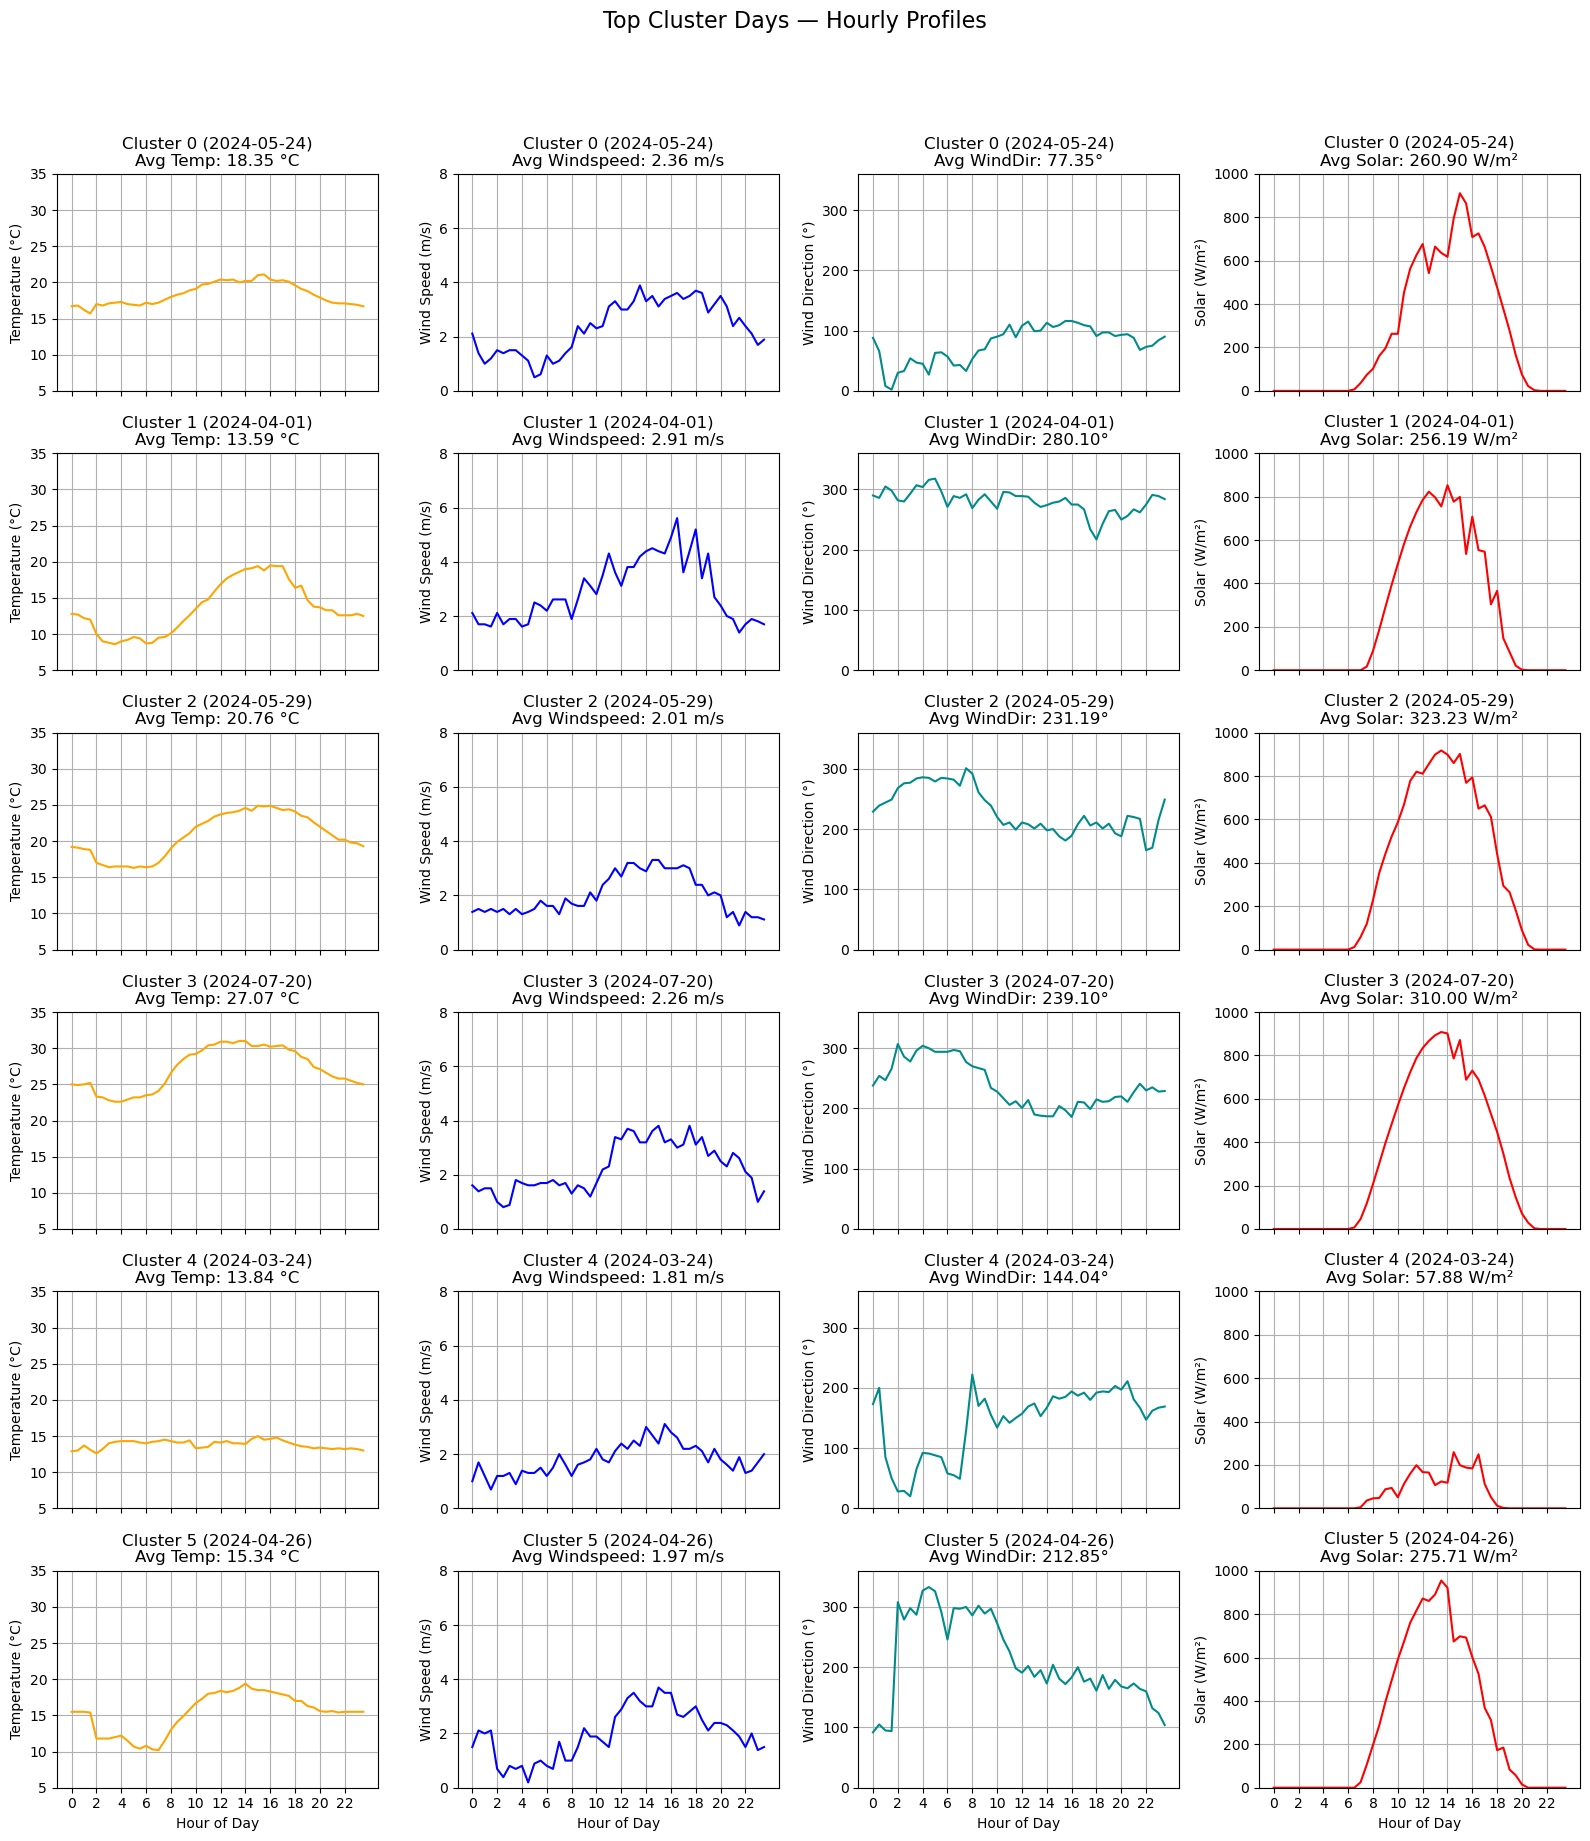

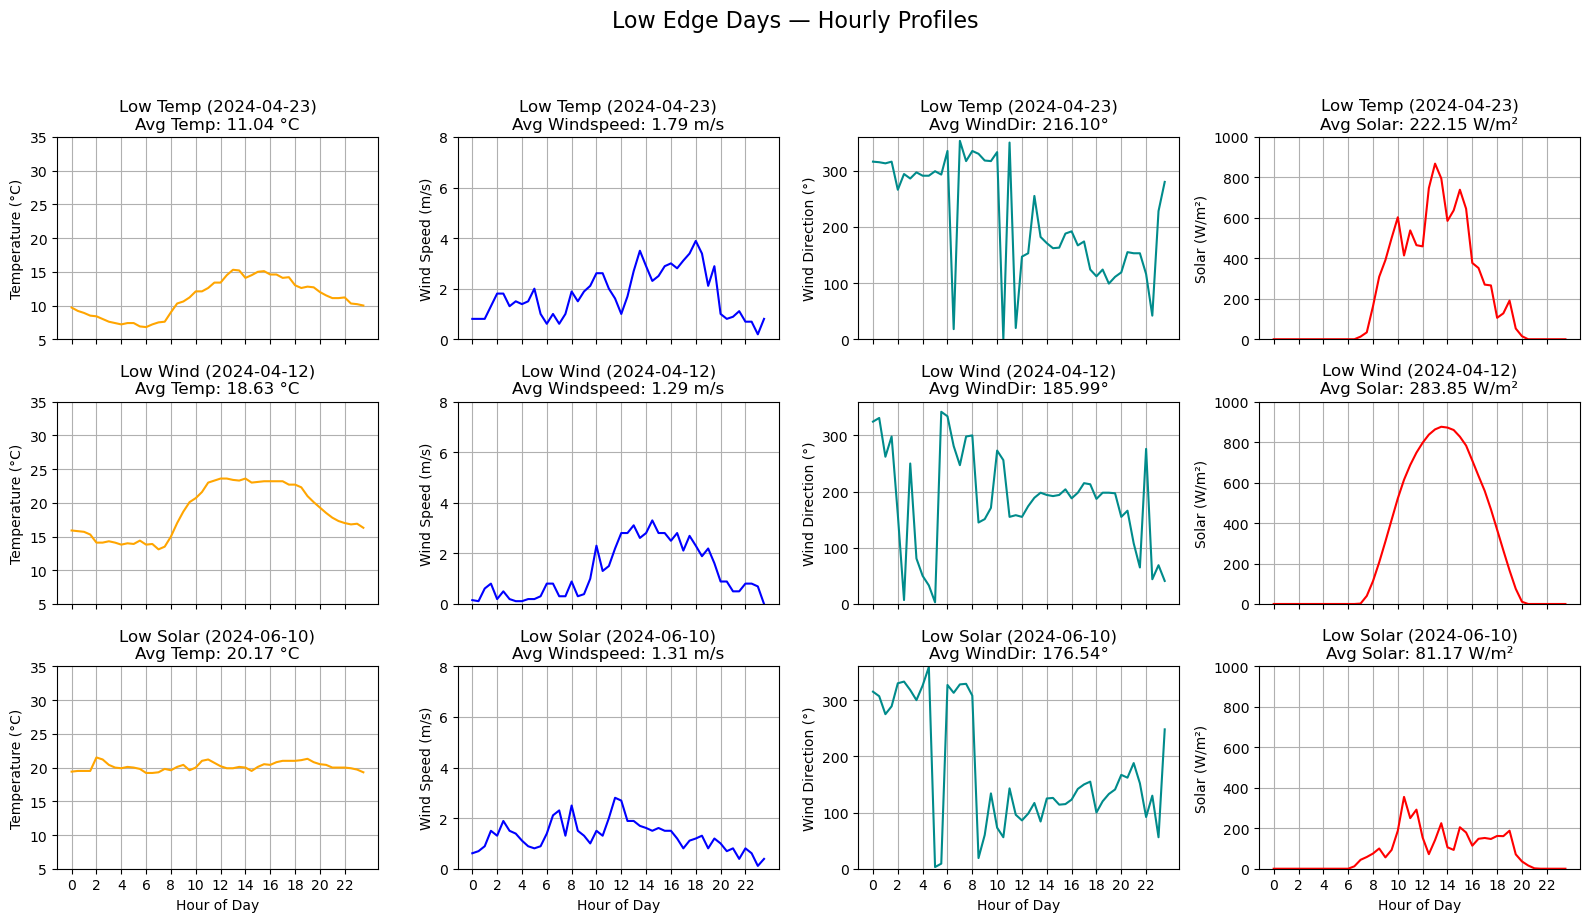

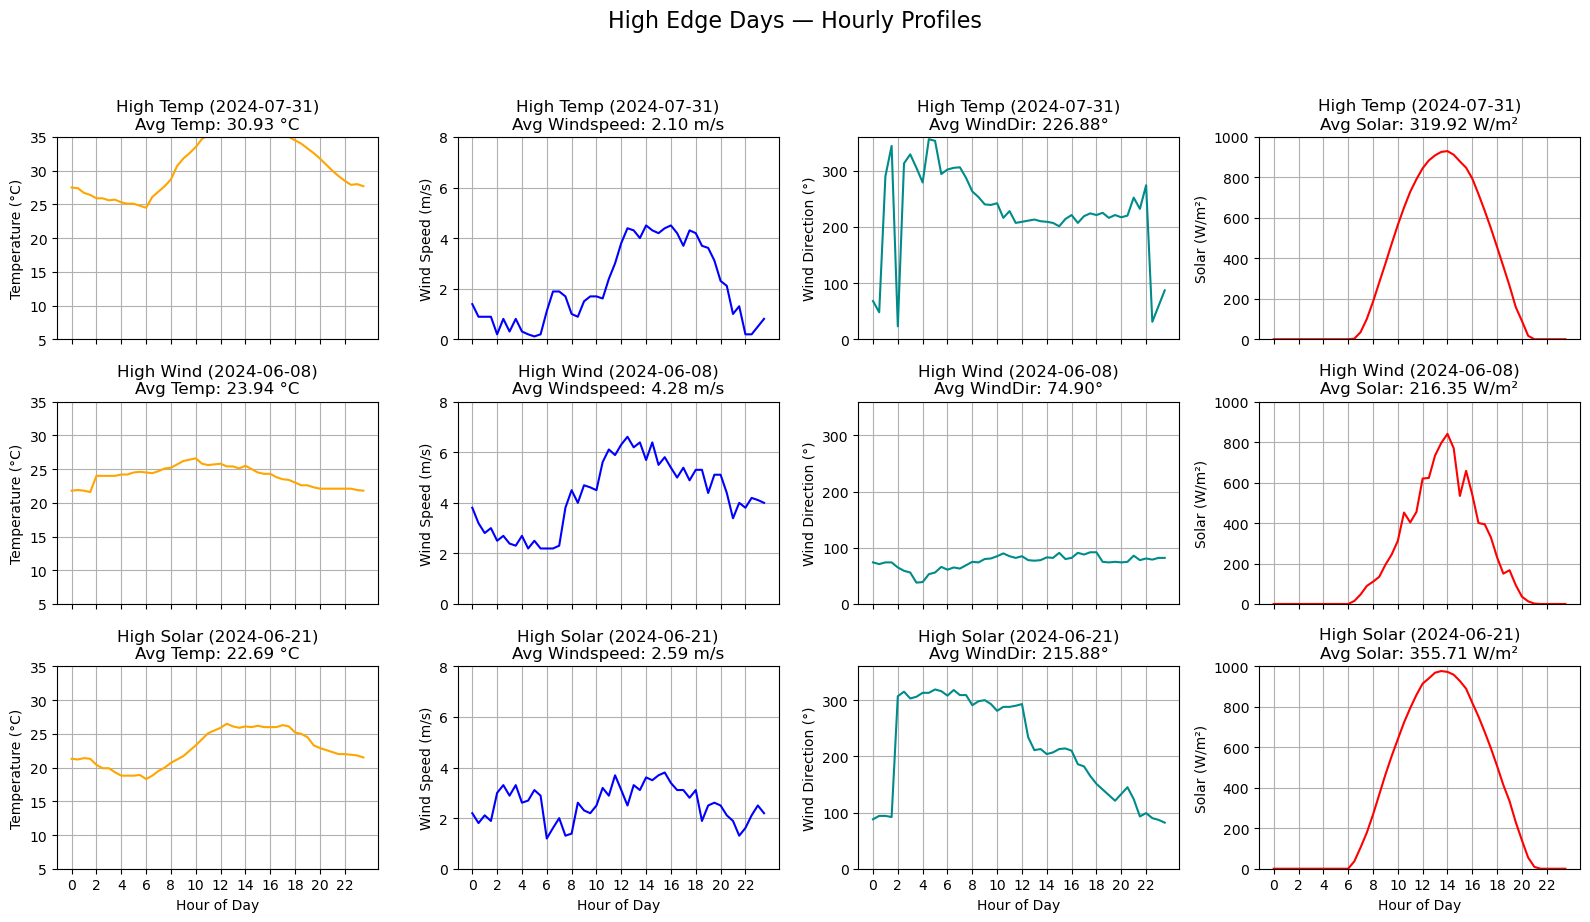

In [12]:
# ==============================
# 15. Define Plot Styles and Visualization Function
# ==============================

# Define plotting styles for each feature
plot_style = {
    'Avg Temperature (C)': {
        'color': 'orange',
        'ylim': (5, 35),
        'ylabel': 'Temperature (°C)',
        'subtitle': lambda s: f"Avg Temp: {s.mean():.2f} °C"
    },
    'Avg Windspeed (m/s)': {
        'color': 'blue',
        'ylim': (0, 8),
        'ylabel': 'Wind Speed (m/s)',
        'subtitle': lambda s: f"Avg Windspeed: {s.mean():.2f} m/s"
    },
    'Avg Wind Direction': {
        'color': 'darkcyan',
        'ylim': (0, 360),
        'ylabel': 'Wind Direction (°)',
        'subtitle': lambda s: f"Avg WindDir: {s.mean():.2f}°"
    },
    'Avg Solar Irradiance (W/m2)': {
        'color': 'red',
        'ylim': (0, 1000),
        'ylabel': 'Solar (W/m²)',
        'subtitle': lambda s: f"Avg Solar: {s.mean():.2f} W/m²"
    }
}

# ==============================
# 16. Function to Plot Selected Days by Group
# ==============================

def plot_days(day_list, suptitle_text, label_list=None):
    fig, axes = plt.subplots(
        nrows=len(day_list),
        ncols=len(feature_list),
        figsize=(4 * len(feature_list), 3 * len(day_list)),
        sharex=True
    )

    # Ensure axes is always 2D
    if len(day_list) == 1:
        axes = [axes]

    for row_idx, day in enumerate(day_list):
        day_df = full_days_merged[full_days_merged['Date'] == day].sort_index()
        for col_idx, feat in enumerate(feature_list):
            ax = axes[row_idx][col_idx]
            ax.plot(
                day_df['Hour'],
                day_df[feat],
                color=plot_style[feat]['color']
            )
            ax.set_ylabel(plot_style[feat]['ylabel'])
            ax.set_ylim(plot_style[feat]['ylim'])
            label_base = label_list[row_idx] if label_list else f""
            label = f"{label_base} ({day})"
            ax.set_title(f"{label}\n{plot_style[feat]['subtitle'](day_df[feat])}")
            ax.grid(True)

    for ax in axes[-1]:
        ax.set_xlabel("Hour of Day")
        ax.set_xticks(range(0, 24, 2))

    plt.suptitle(f"{suptitle_text} — Hourly Profiles", fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# ==============================
# 17. Visualize Cluster, Low, and High Extreme Days
# ==============================

# Cluster-representative days
cluster_labels = [
    f"Cluster {k}" for k, d in zip(representative_days_dict.keys(), cluster_top_days)
    if d in filtered_cluster_top_days
]
plot_days(filtered_cluster_top_days, "Top Cluster Days", cluster_labels)

# Lowest extreme days
lowest_labels = ['Low Temp', 'Low Wind', 'Low Solar']
plot_days(filtered_lowest_extreme_days, "Low Edge Days", lowest_labels[:len(filtered_lowest_extreme_days)])

# Highest extreme days
highest_labels = ['High Temp', 'High Wind', 'High Solar']
plot_days(filtered_highest_extreme_days, "High Edge Days", highest_labels[:len(filtered_highest_extreme_days)])

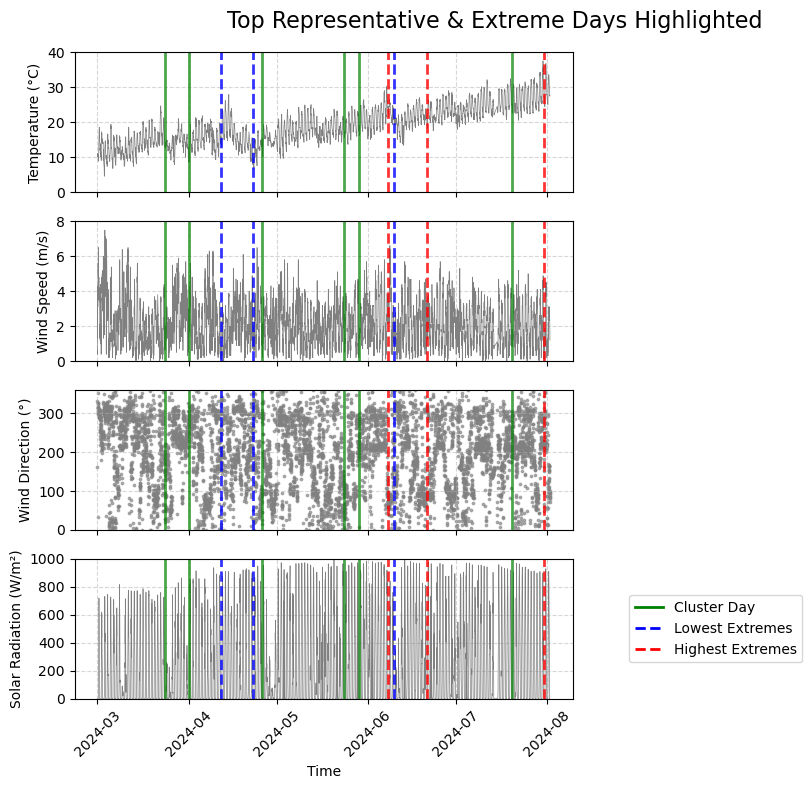

In [13]:
# ==============================
# 17. Highlight Cluster and Extreme Days on Full Dataset
# ==============================

# Ensure windspeed in m/s exists
if 'Avg Windspeed (m/s)' not in data.columns:
    data['Avg Windspeed (m/s)'] = data['Avg Windspeed (km/h)'] / 3.6

# Create subplots for full dataset
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Plot 1: Temperature
axes[0].plot(data.index, data['Avg Temperature (C)'], color='gray', linewidth=0.5)
axes[0].set_ylim(0, 40)
axes[0].set_ylabel("Temperature (°C)")
axes[0].grid(True, linestyle="--", alpha=0.5)

# Plot 2: Wind Speed
axes[1].plot(data.index, data['Avg Windspeed (m/s)'], color='gray', linewidth=0.5)
axes[1].set_ylim(0, 8)
axes[1].set_ylabel("Wind Speed (m/s)")
axes[1].grid(True, linestyle="--", alpha=0.5)

# Plot 3: Wind Direction
axes[2].scatter(data.index, data['Avg Wind Direction'], color='gray', s=3, alpha=0.6)
axes[2].set_ylim(0, 360)
axes[2].set_ylabel("Wind Direction (°)")
axes[2].grid(True, linestyle="--", alpha=0.5)

# Plot 4: Solar Radiation
axes[3].plot(data.index, data['Avg Solar Irradiance (W/m2)'], color='gray', linewidth=0.5)
axes[3].set_ylim(0, 1000)
axes[3].set_ylabel("Solar Radiation (W/m²)")
axes[3].set_xlabel("Time")
axes[3].grid(True, linestyle="--", alpha=0.5)

plt.xticks(rotation=45)

# ==============================
# Add Highlighted Vertical Lines for Selected Days
# ==============================

# Define colors and labels for day types
line_styles = {
    'Cluster': {'color': 'green', 'label': 'Cluster Day'},
    'Lowest': {'color': 'blue', 'label': 'Lowest Extremes'},
    'Highest': {'color': 'red', 'label': 'Highest Extremes'}
}

# Highlight Cluster Days
for date in filtered_cluster_top_days:
    dt = pd.to_datetime(date)
    for ax in axes:
        ax.axvline(dt, color=line_styles['Cluster']['color'], linewidth=2, alpha=0.7)

# Highlight Lowest Extreme Days
for date in filtered_lowest_extreme_days:
    dt = pd.to_datetime(date)
    for ax in axes:
        ax.axvline(dt, color=line_styles['Lowest']['color'], linestyle='--', linewidth=2, alpha=0.8)

# Highlight Highest Extreme Days
for date in filtered_highest_extreme_days:
    dt = pd.to_datetime(date)
    for ax in axes:
        ax.axvline(dt, color=line_styles['Highest']['color'], linestyle='--', linewidth=2, alpha=0.8)

# ==============================
# Add Legend and Final Formatting
# ==============================

# Define legend handles
handles = [
    mlines.Line2D([], [], color=line_styles['Cluster']['color'], linewidth=2, label=line_styles['Cluster']['label']),
    mlines.Line2D([], [], color=line_styles['Lowest']['color'], linestyle='--', linewidth=2, label=line_styles['Lowest']['label']),
    mlines.Line2D([], [], color=line_styles['Highest']['color'], linestyle='--', linewidth=2, label=line_styles['Highest']['label']),
]
plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1.1, 0.5))

# Final plot adjustments
plt.suptitle("Top Representative & Extreme Days Highlighted", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

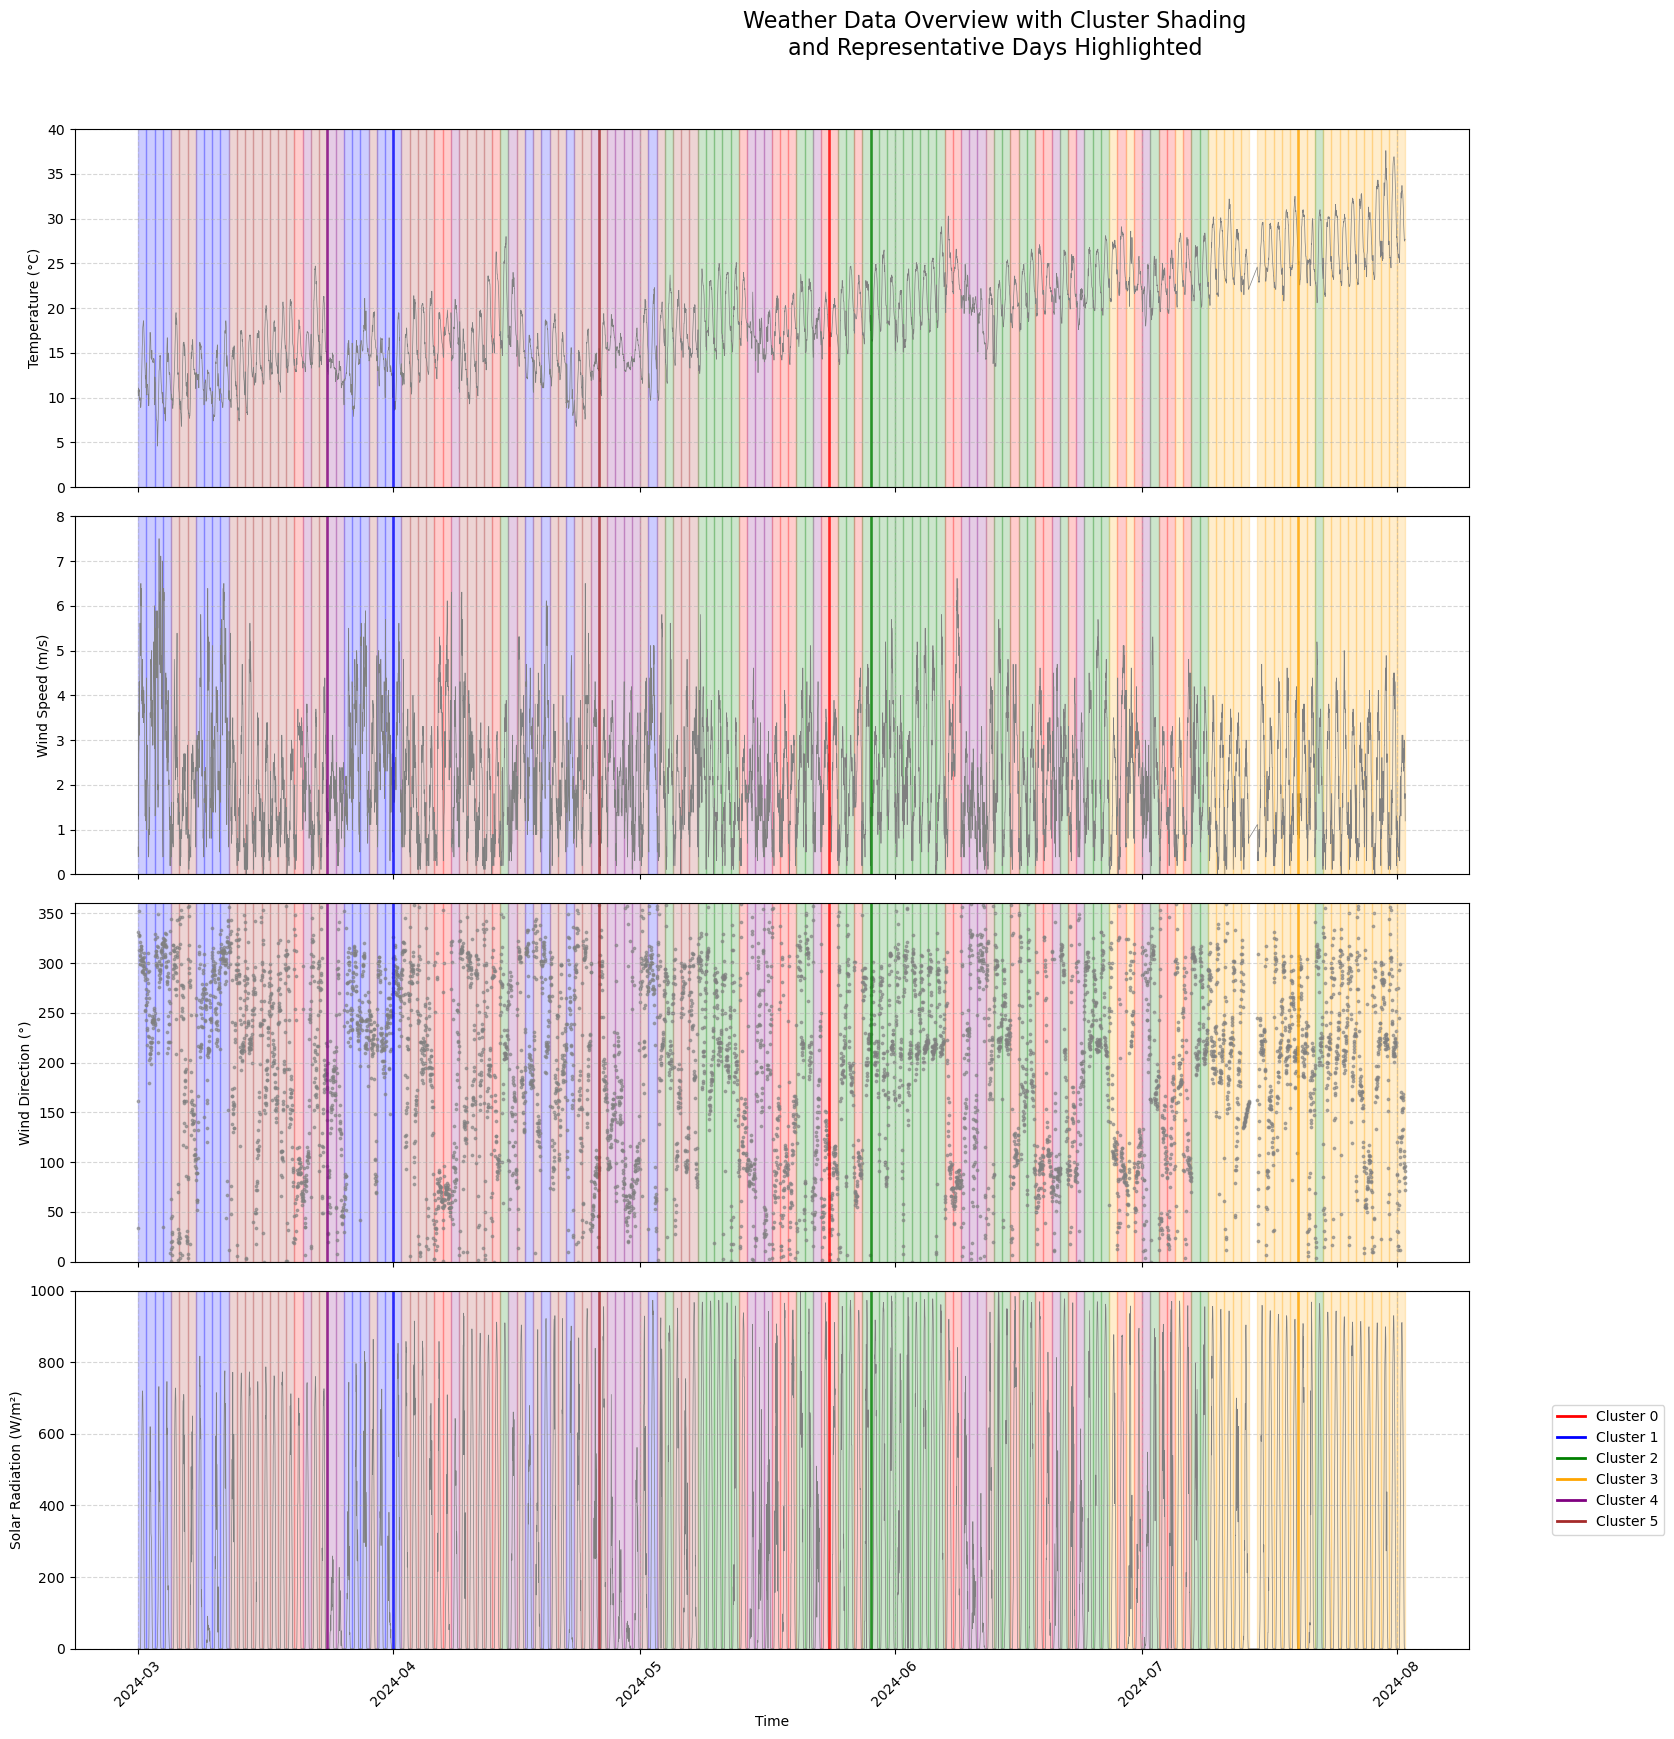

In [14]:
# ==============================
# 18. Visualize Weather Data with Cluster Shading and Representative Days
# ==============================

# Ensure wind speed in m/s exists
if 'Avg Windspeed (m/s)' not in data.columns:
    data['Avg Windspeed (m/s)'] = data['Avg Windspeed (km/h)'] / 3.6

# Create subplots for full weather dataset
fig, axes = plt.subplots(4, 1, figsize=(20, 17), sharex=True)

# Plot 1: Temperature
axes[0].plot(data.index, data['Avg Temperature (C)'], color='gray', linewidth=0.5)
axes[0].set_ylim(0, 40)
axes[0].set_ylabel("Temperature (°C)")
axes[0].grid(True, linestyle="--", alpha=0.5)

# Plot 2: Wind Speed
axes[1].plot(data.index, data['Avg Windspeed (m/s)'], color='gray', linewidth=0.5)
axes[1].set_ylim(0, 8)
axes[1].set_ylabel("Wind Speed (m/s)")
axes[1].grid(True, linestyle="--", alpha=0.5)

# Plot 3: Wind Direction
axes[2].scatter(data.index, data['Avg Wind Direction'], color='gray', marker='o', s=3, alpha=0.6)
axes[2].set_ylim(0, 360)
axes[2].set_ylabel("Wind Direction (°)")
axes[2].grid(True, linestyle="--", alpha=0.5)

# Plot 4: Solar Radiation
axes[3].plot(data.index, data['Avg Solar Irradiance (W/m2)'], color='gray', linewidth=0.5)
axes[3].set_ylim(0, 1000)
axes[3].set_ylabel("Solar Radiation (W/m²)")
axes[3].set_xlabel("Time")
axes[3].grid(True, linestyle="--", alpha=0.5)

plt.xticks(rotation=45)

# ==============================
# Shade Days According to Cluster Assignment
# ==============================

# Define colors for each cluster
cluster_colors = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'purple',
    5: 'brown'
}

# Shade background of each day based on cluster
for _, row in daily_cluster_df.iterrows():
    day_dt = pd.to_datetime(row['Date'])
    cluster_label = row['Cluster']
    for ax in axes:
        ax.axvspan(day_dt, day_dt + pd.Timedelta(days=1),
                   color=cluster_colors.get(cluster_label, 'gray'),
                   alpha=0.2, zorder=0)

# ==============================
# Highlight Representative Days
# ==============================

# Draw vertical lines for top representative day of each cluster
for cluster, day_list in representative_days_dict.items():
    if not day_list:
        continue
    top_day = day_list[0]
    rep_datetime = pd.to_datetime(top_day)
    for ax in axes:
        ax.axvline(rep_datetime,
                   color=cluster_colors.get(cluster, 'black'),
                   linestyle='-',
                   linewidth=2,
                   alpha=0.7)

# ==============================
# Add Legend and Final Formatting
# ==============================

# Create legend for cluster colors
legend_handles = [
    mlines.Line2D([], [], color=color, linestyle='-', linewidth=2, label=f'Cluster {cluster}')
    for cluster, color in cluster_colors.items()
]
plt.legend(handles=legend_handles, loc='center', bbox_to_anchor=(1.1, 0.5))

# Final plot adjustments
plt.suptitle("Weather Data Overview with Cluster Shading\nand Representative Days Highlighted", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()